In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Useful packages

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from random import seed

seed(0)

In [3]:
# Data loading

train_titanic=pd.read_csv("train.csv")

test_titanic=pd.read_csv("test.csv")

In [4]:
train_titanic.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [5]:
train_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
test_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


## Data description

We have eleven variables:

    - PassengerId: Primary key that are unique for each passenger
    - Survived: feature that gives information about the status of a passenger after accident,
    (0/1)-(Died/Survived)
    - Pclass: The class that the passager was embarked
    - Name: Name of the passenger
    - Sex: gender of the passenger
    - Age : Age of passenger
    - SibSp: Number of siblings/spouse on board of titanic
    - Parch: Number of parent/children on board of titanic
    - Ticket: Ticket number
    - Fare: Price of passenger's ticket 
    - Cabin: Cabin number
    - Embarked: Port of embarkation

### Feature engineering

As we have a contraint to respect the submission file structure and his shape. We can't drop any line. Then we will deal with missing value by trying different method of filling these missing and consider the best predictablility outcome.

In [7]:
# Fill embarked nan value

train_titanic["Embarked"]=train_titanic["Embarked"].fillna(train_titanic["Embarked"].mode().iloc[0])
test_titanic["Embarked"]=test_titanic["Embarked"].fillna(test_titanic["Embarked"].mode().iloc[0])

In [8]:
# According to the evolution of distribution before and after filling we will consider ["nearest","linear"]

def fill_nan_age(df,method):
    
    df["Age"]=df["Age"].interpolate(method =method, limit_direction ='forward')

    return df

train_titanic=fill_nan_age(train_titanic,method='nearest')

test_titanic=fill_nan_age(test_titanic,method="nearest")

test_titanic=fill_nan_age(test_titanic,method='barycentric')


In [9]:
## Fill fare NaN in test_titanic
test_titanic[test_titanic["Fare"].isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [10]:
test_titanic[test_titanic["Pclass"]==3][test_titanic["Age"]>=58]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,6.050000e+01,0,0,3701,NaN,NaN,S
344,1236,3,"van Billiard, Master. James William",male,5.800000e+01,1,1,A/5. 851,14.5000,NaN,S
357,1249,3,"Lockyer, Mr. Edward",male,5.900000e+01,0,0,1222,7.8792,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,7.752795e+15,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,6.826257e+15,1,1,2668,22.3583,NaN,C


In [11]:
#Based on Age and Pclass, I will with fare value that is near of 
# the age of missing observation and according to the class related
test_titanic["Fare"]=test_titanic["Fare"].replace(np.NaN,14.5)

#### Hypothesis

Is it possible to predict cabin based on they paid and the chance of surviving?

### Question
How to split Fare to match the correct Cabin?

In [12]:
#https://titanic.fandom.com/wiki/First_Class_Staterooms#A_Deck

class_1=['A','B','C','D','E']
privileged=['B51','B53','B54','B55','B56']
class_2=[]
class_3=[]

#train_titanic["Cabin"].unique()

In [13]:
train_titanic["Cabin"].dropna().nunique()/train_titanic.shape[0]

0.16498316498316498

We have just 16.5% of unique cabin number. Then it will be interesting if we have at least one available value for cabin label for each unique prices.

In [14]:
train_titanic["Fare"].nunique()/train_titanic.shape[0]

0.2783389450056117

So interesting because there are many redundant price then it mean that cabin and class will be positive associated with Fare then we can fill `NaN` with more sure value.

In [15]:
def check_list_items(l):

    for item in l:

        if str(item)!='nan':

            return item

    return np.NaN
    
def get_unique_cabin_per_fare(train_titanic):
    
    final_fare_label=dict()

    train_titanic["Fare"]=train_titanic["Fare"].astype('int64')

    nan_cabin_fare=[]

    for fare in train_titanic[train_titanic["Cabin"].isna()]["Fare"].unique():
        
        relate_cabin=[]

        for cabin in train_titanic[train_titanic["Fare"]==fare]["Cabin"]:

            if cabin not in relate_cabin:

                relate_cabin.append(cabin)
        
        final_fare_label[fare]=check_list_items(relate_cabin)
    
    return final_fare_label

In [16]:
final_fare_label_train=get_unique_cabin_per_fare(train_titanic)
final_fare_label_test=get_unique_cabin_per_fare(test_titanic)

In [17]:
def get_not_defined_cabin_fare(final_fare_label):

    fares_nan=[]
    fares_defined={}

    for fare in final_fare_label.keys():

        if str(final_fare_label[fare])=='nan':

            fares_nan.append(fare)
        
        else:

            fares_defined[fare]=final_fare_label[fare]

    return fares_defined,fares_nan

In [18]:
fares_defined_train,fares_nan_train=get_not_defined_cabin_fare(final_fare_label_train)
fares_defined_test,fares_nan_test=get_not_defined_cabin_fare(final_fare_label_test)

In [19]:
#

def find_most_likely_cabin(fares_defined,fares_nan):

    most_likely_cabin={}

    for fare in fares_nan:

        difference=abs(list(fares_defined.keys())-fare)
        
        index=list(difference).index(min(difference))

        most_likely_cabin[fare]=list(fares_defined.values())[index]

    return most_likely_cabin

In [20]:
most_likely_cabin_train=find_most_likely_cabin(fares_defined_train,fares_nan_train)
most_likely_cabin_test=find_most_likely_cabin(fares_defined_test,fares_nan_test)

In [21]:
fares_defined_train.update(most_likely_cabin_train)

fares_defined_test.update(most_likely_cabin_test)

In [22]:
#Creating new columns for cabin

def construct_new_cabin_col(train_titanic,fares_defined):

    col_Cabin={'Fare':[]}

    for fare,cabin in zip(train_titanic["Fare"],train_titanic["Cabin"]):

        if str(cabin)=='nan':

            col_Cabin['Fare'].append(fares_defined[fare])

        else:
            
            col_Cabin['Fare'].append(cabin)
    
    return col_Cabin

In [23]:
col_cabin_train=construct_new_cabin_col(train_titanic,fares_defined_train)

col_cabin_test=construct_new_cabin_col(test_titanic,fares_defined_test)

In [24]:
train_titanic["Cabin_new"]=col_cabin_train["Fare"]
test_titanic["Cabin_new"]=col_cabin_test["Fare"]

In [25]:
train_titanic.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Cabin_new        0
dtype: int64

In [26]:
test_titanic.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
Cabin_new        0
dtype: int64

## Exporting the processed dataset for Modelisation

In [27]:
train_titanic.drop(columns=["PassengerId","Name","Cabin","Ticket"]).to_csv("train_processed.csv",index=False)
test_titanic.drop(columns=["PassengerId","Name","Cabin","Ticket"]).to_csv("test_processed.csv",index=False)

train_titanic=pd.read_csv("train_processed.csv")
test_titanic=pd.read_csv("test_processed.csv")

In [28]:
train_titanic.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_new
0,0,3,male,22.0,1,0,7,S,F G73
1,1,1,female,38.0,1,0,71,C,C85


### Encodage des variables

In [29]:
#Train data

train_titanic['Pclass']=train_titanic['Pclass'].astype('category')

# Test data

test_titanic['Pclass']=test_titanic['Pclass'].astype('category')

In [30]:

train_titanic['Cabin_new']=train_titanic['Cabin_new'].apply(lambda x:str(x).strip()[0])

test_titanic['Cabin_new']=test_titanic['Cabin_new'].apply(lambda x:str(x).strip()[0])

In [31]:
train_titanic[train_titanic["Fare"]==35]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_new
23,1,1,male,28.0,0,0,35,S,A
55,1,1,male,65.0,0,0,35,S,C
339,0,1,male,45.0,0,0,35,S,T
351,0,1,male,23.0,0,0,35,S,C
647,1,1,male,56.0,0,0,35,C,A


In [32]:
# As there are no cabin with T in test set then to keep the same format in test and train set
# We will replace T by C that is more similar to this view based on other attributes

train_titanic['Cabin_new']=train_titanic['Cabin_new'].replace('T','C') 

In [33]:
train_titanic["Cabin_new"].unique()

array(['F', 'C', 'E', 'A', 'G', 'D', 'B'], dtype=object)

In [34]:
train_titanic_numeric=pd.get_dummies(train_titanic)

test_titanic_numeric=pd.get_dummies(test_titanic)

train_titanic_numeric.shape,test_titanic_numeric.shape

((891, 20), (418, 19))

### Modelisation

In [35]:
from sklearn.linear_model import LogisticRegression

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report,confusion_matrix

In [36]:
lr_model=LogisticRegression(penalty="l2",class_weight="balanced")
LDA=LinearDiscriminantAnalysis()
KNN=KNeighborsClassifier(n_neighbors=2,n_jobs=-1)

In [37]:
y=train_titanic_numeric["Survived"]
X=train_titanic_numeric.drop(columns=["Survived"])

In [38]:
X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=.1)

In [39]:
lr_model.fit(X_train,y_train)
LDA.fit(X_train,y_train)
KNN.fit(X_train,y_train)


KNeighborsClassifier(n_jobs=-1, n_neighbors=2)

In [40]:
lr_model.score(X_train,y_train),LDA.score(X_train,y_train),KNN.score(X_train,y_train)

(0.7915106117353309, 0.8039950062421972, 0.8164794007490637)

# Optimisation

In [41]:
from sklearn.model_selection import GridSearchCV

### Logistic Regression

In [42]:
grid={"C":np.logspace(-3,3,10), "penalty":["l1","l2","elasticnet"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)

print("Accuracy for our training dataset with tuning is : {:.2%}".format(logreg_cv.best_score_) )

tuned hpyerparameters :(best parameters)  {'C': 0.021544346900318832, 'penalty': 'l2'}
Accuracy for our training dataset with tuning is : 79.28%


In [43]:
y_predict=logreg_cv.predict(X_valid)

print(classification_report(y_valid,y_predict))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90        60
           1       0.82      0.77      0.79        30

    accuracy                           0.87        90
   macro avg       0.85      0.84      0.85        90
weighted avg       0.87      0.87      0.87        90



<Figure size 1000x1400 with 0 Axes>

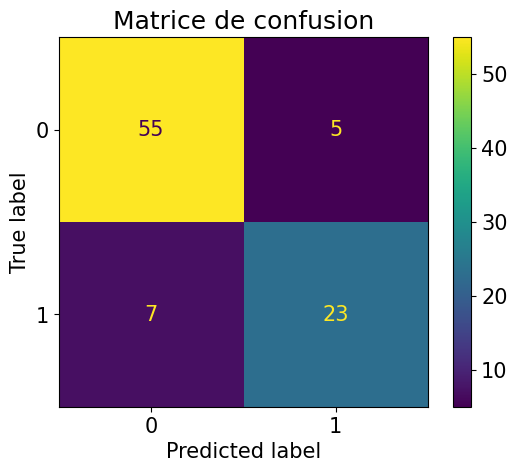

In [44]:
from sklearn import metrics

#Calcul de la matrice de confusion
y_valid_pred=logreg_cv.predict(X_valid)
confu_mat=metrics.confusion_matrix(y_valid,y_valid_pred)
cm_obj=metrics.ConfusionMatrixDisplay(confu_mat,
                                      #display_labels=randomforest.
                                     )
plt.figure(figsize=(10,14))
plt.rcParams.update({'font.size':15})
cm_obj.plot()
cm_obj.ax_.set(title='Matrice de confusion')

plt.show()

In [45]:
from sklearn.model_selection import ShuffleSplit, cross_val_score

shufflesplit=ShuffleSplit(n_splits=20, test_size=0.2,random_state=0)
results=cross_val_score(logreg_cv,X_valid,y_valid,cv=shufflesplit)
print(f"Le score moyen sur la capacité prédictif du modèle:{np.mean(results):.2%} with std:{np.std(results):.2%}")

Le score moyen sur la capacité prédictif du modèle:84.17% with std:7.30%


### Submission

In [46]:
submi_lr=pd.read_csv("gender_submission.csv")

submi_lr["Survived"]=logreg_cv.predict(test_titanic_numeric)

In [47]:
submi_lr.to_csv("submi_lr.csv",index=False)

### KNeighborsClassifier

In [48]:
KNN = KNeighborsClassifier()
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(KNN, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search_knn=grid.fit(X_train, y_train)


print(grid_search_knn.best_params_)

print("Accuracy for our training dataset with tuning is : {:.2%}".format(grid_search_knn.best_score_) )

Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'n_neighbors': 3}
Accuracy for our training dataset with tuning is : 69.43%


In [49]:
y_predict=grid_search_knn.predict(X_valid)

print(classification_report(y_valid,y_predict))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83        60
           1       0.67      0.60      0.63        30

    accuracy                           0.77        90
   macro avg       0.74      0.72      0.73        90
weighted avg       0.76      0.77      0.76        90



In [50]:
from sklearn.model_selection import ShuffleSplit, cross_val_score

shufflesplit=ShuffleSplit(n_splits=10, test_size=0.2,random_state=0)
results=cross_val_score(grid_search_knn,X_valid,y_valid,cv=shufflesplit)
print(f"Le score moyen sur la capacité prédictif du modèle:{np.mean(results):.2%} with std:{np.std(results):.2%}")

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Le score moyen sur la capacité prédictif du modèle:69.44% with std:11.18%


### Important variable for survival modelling

In [51]:
from sklearn.feature_selection import chi2,SelectKBest,RFE,f_classif

selector=SelectKBest(score_func=f_classif)

# Entrainnement de la méthode
selector_fitted=selector.fit(X_train,y_train)

print("Significant variables in modeling passenger survival: ",X_train.columns[selector_fitted.get_support()])

Significant variables in modeling passenger survival:  Index(['Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_S', 'Cabin_new_C', 'Cabin_new_F'],
      dtype='object')


<Figure size 1000x1400 with 0 Axes>

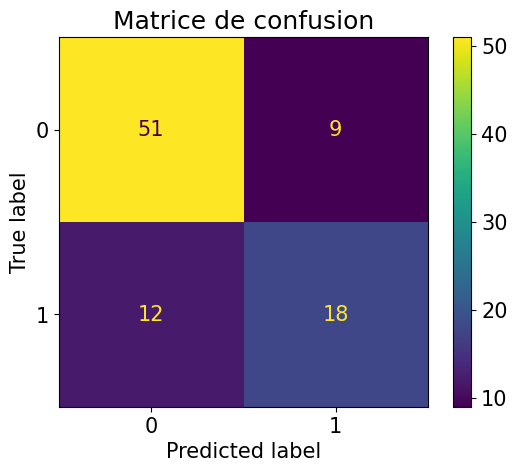

In [52]:
#Calcul de la matrice de confusion
y_valid_pred=grid_search_knn.predict(X_valid)
confu_mat=metrics.confusion_matrix(y_valid,y_valid_pred)
cm_obj=metrics.ConfusionMatrixDisplay(confu_mat,
                                      #display_labels=randomforest.
                                     )
plt.figure(figsize=(10,14))
plt.rcParams.update({'font.size':15})
cm_obj.plot()
cm_obj.ax_.set(title='Matrice de confusion')

plt.show()

### Submission

In [53]:
submi_knn=pd.read_csv("gender_submission.csv")

submi_knn["Survived"]=grid_search_knn.predict(test_titanic_numeric)

In [54]:
submi_knn.to_csv("submi_knn.csv",index=False)

### LinearDiscriminantAnalysis 

In [55]:
grid=dict()
grid['solver']=['svd', 'lsqr', 'eigen']

lda_search=GridSearchCV(LDA, grid, scoring='accuracy', cv=10, n_jobs=-1 )

lda_search.fit(X_train,y_train)

print(lda_search.best_params_)

print("Accuracy for our training dataset with tuning is : {:.2%}".format(lda_search.best_score_) )

{'solver': 'svd'}
Accuracy for our training dataset with tuning is : 78.78%


In [56]:
y_predict=lda_search.predict(X_valid)

print(classification_report(y_valid,y_predict))

              precision    recall  f1-score   support

           0       0.95      0.87      0.90        60
           1       0.77      0.90      0.83        30

    accuracy                           0.88        90
   macro avg       0.86      0.88      0.87        90
weighted avg       0.89      0.88      0.88        90



In [57]:
from sklearn.model_selection import ShuffleSplit, cross_val_score

shufflesplit=ShuffleSplit(n_splits=20, test_size=0.2,random_state=0)
results=cross_val_score(lda_search,X_valid,y_valid,cv=shufflesplit)
print(f"Le score moyen sur la capacité prédictif du modèle:{np.mean(results):.2%} with std:{np.std(results):.2%}")

Le score moyen sur la capacité prédictif du modèle:85.28% with std:10.73%


<Figure size 1000x1400 with 0 Axes>

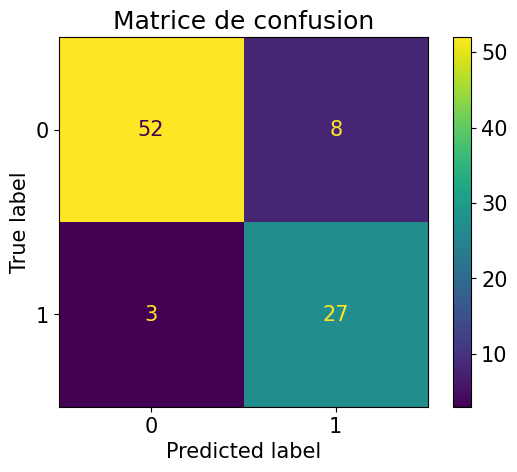

In [58]:
#Calcul de la matrice de confusion
y_valid_pred=lda_search.predict(X_valid)
confu_mat=metrics.confusion_matrix(y_valid,y_valid_pred)
cm_obj=metrics.ConfusionMatrixDisplay(confu_mat,
                                      #display_labels=randomforest.
                                     )
plt.figure(figsize=(10,14))
plt.rcParams.update({'font.size':15})
cm_obj.plot()
cm_obj.ax_.set(title='Matrice de confusion')

plt.show()

### Submission

In [59]:
submi_lda=pd.read_csv("gender_submission.csv")
submi_lda["Survived"]=lda_search.predict(test_titanic_numeric)

In [60]:
submi_lda.to_csv("submi_lda.csv",index=False)